In [445]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as ptch

from datetime import datetime
import time
from os import listdir
from os.path import isfile, join

plt.style.use('fivethirtyeight')
plt.style.use('bmh')

# Non-Pharmaceutical Interventions in Canada

Here we show comparisons of descriptive statistics for each regional and subregional-level dataset across Canada. Download individual region CSVs from the Google Sheet and place them in `./data/`. 

Stats Canada data on population size by province available from: 

Statistics Canada. Table 17-10-0009-01 Population estimates, quarterly"
https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710000901
DOI: https://doi.org/10.25318/1710000901-eng


In [472]:
stats_columns=[
    'file',
    'region',
    'subregion', 
    'rows',
    'columns',
    'start_date.min', 
    'start_date.max', 
    'end_date.min', 
    'end_date.max', 
    'end_date.count / count', 
    'reviewer.unique', 
    'intervention_summary.unique', 
    'intervention_category.unique',
    'target_population_category.unique',
    'target_population_category (% not "General")',
    'enforcement_category.unique',
    'oxford_government_response_category.unique',
    'oxford_fiscal_measure_cad.sum',
    'source_url.unique'
]

columns=[
    'start_date',
    'end_date',
    'reviewer',
    'country',
    'region',
    'subregion',
    'intervention_summary',
    'intervention_category',
    'target_population_category',
    'enforcement_category',
    'oxford_government_response_category',
    'oxford_closure_code',
    'oxford_public_info_code',
    'oxford_travel_code',
    'oxford_geographic_target_code',
    'oxford_fiscal_measure_cad',
    'oxford_monetary_measure',
    'oxford_testing_code',
    'oxford_tracing_code',
    'source_url',
    'source_organization',
    'source_organization_2',
    'source_category',
    'source_title',
    'source_full_text',
    'note'
]

province_files = ['Prince Edward Island.csv', 'Newfoundland and Labrador.csv', 'Alberta.csv', 
             'British Columbia.csv', 'Yukon.csv', 'Saskatchewan.csv',
             'Ontario.csv', 'Nova Scotia.csv', 'New Brunswick.csv',
             'Nunavut.csv', 'Quebec.csv', 'Northwest Territories.csv', 'Manitoba.csv']

In [525]:
population_df = pd.read_csv('statscan-population-q.csv', thousands=',')
population_df[['Geography', 'Q1 2020']]
population_df['region'] = population_df['Geography']
population_df['population_q1_2020'] = pd.to_numeric(population_df['Q1 2020'])
population_df = population_df[['region', 'population_q1_2020']]
population_df

,region,population_q1_2020
0,Canada,37894799
1,Newfoundland and Labrador,521365
2,Prince Edward Island,158158
3,Nova Scotia,977457
4,New Brunswick,779993
5,Quebec,8537674
6,Ontario,14711827
7,Manitoba,1377517
8,Saskatchewan,1181666
9,Alberta,4413146


In [562]:
data_path = './data/'
csvs = [f for f in listdir(data_path) if isfile(join(data_path, f))]
stats_df = pd.DataFrame(columns=stats_columns)

full_df = pd.DataFrame(columns=columns)
provinces_df = pd.DataFrame(columns=columns)

#print(csvs)
for file in csvs:
    if file == ".DS_Store":
        continue
    print('Reading ', file)
    name = file.split("-", 1)[-1].strip(' ')
    df = pd.read_csv(data_path + file)
    df['start_date'] = pd.to_datetime(df['start_date'], format='%m/%d/%Y')
    df['end_date'] = pd.to_datetime(df['end_date'], format='%m/%d/%Y')
    df['oxford_fiscal_measure_cad'] = df['oxford_fiscal_measure_cad'].replace('[\$,]', '', regex=True).astype(float)
    
    full_df = full_df.append(df)
    if name in province_files:
        provinces_df = provinces_df.append(df)
    
    mode_sub = df['subregion'].mode()[0] if len(df['subregion'].mode()) > 0 else ''
    stats = [
        name,
        df['region'].mode()[0],
        mode_sub,
        df.shape[0],
        df.shape[1],
        df['start_date'].min(),
        df['start_date'].max(),
        df['end_date'].min(),
        df['end_date'].max(),
        len(df['end_date'].unique()) / df.shape[0],
        len(df['reviewer'].unique()),
        len(df['intervention_summary'].unique()),
        len(df['intervention_category'].unique()),
        len(df['target_population_category'].unique()),
        df[df['target_population_category'] != 'General'].shape[0] / df.shape[0],
        len(df['enforcement_category'].unique()),
        len(df['oxford_government_response_category'].unique()),
        df['oxford_fiscal_measure_cad'].sum(), 
        len(df['source_url'].unique()), 
    ]
    file_stats_df = pd.DataFrame([stats], columns=stats_columns)
    stats_df = pd.concat([stats_df, file_stats_df], ignore_index=True)

full_df = full_df.reindex(columns=columns)
provinces_df = provinces_df.reindex(columns=columns)


Reading  Collecting NPIs Effects - Northwest Territories.csv
Reading  Collecting NPIs Effects - Calgary, AB.csv
Reading  Collecting NPIs Effects - Kelowna, BC.csv
Reading  Collecting NPIs Effects - Winnipeg, MB.csv
Reading  Collecting NPIs Effects - Montreal, QC.csv
Reading  Collecting NPIs Effects - Ottawa-Gatineau.csv
Reading  Collecting NPIs Effects - Victoria, BC.csv
Reading  Collecting NPIs Effects - Edmonton, AB.csv
Reading  Collecting NPIs Effects - Vancouver, BC.csv
Reading  Collecting NPIs Effects - Toronto, ON.csv
Reading  Collecting NPIs Effects - Regina, SK.csv
Reading  Collecting NPIs Effects - Alberta.csv
Reading  Collecting NPIs Effects - London, ON.csv
Reading  Collecting NPIs Effects - British Columbia.csv
Reading  Collecting NPIs Effects - Quebec City, QC.csv
Reading  Collecting NPIs Effects - St. John's, NL.csv
Reading  Collecting NPIs Effects - Halifax, NS.csv
Reading  Collecting NPIs Effects - Yukon.csv
Reading  Collecting NPIs Effects - Saskatchewan.csv
Reading  C

Write out the merged CSV.

In [563]:
full_df.drop(columns=['reviewer']).to_csv('npi_full.csv')
provinces_df.drop(columns=['reviewer']).to_csv('npi_by_province.csv')

In [565]:
nb = provinces_df[provinces_df['region'] == 'Nova Scotia']
nb[nb['oxford_fiscal_measure_cad'].notna()][['start_date', 'intervention_summary', 'oxford_fiscal_measure_cad']]

,start_date,intervention_summary,oxford_fiscal_measure_cad
36,2020-03-19,Financial aid to vulnerable individuals,3200000.0
38,2020-03-20,Financial measures to support small and medium...,161000000.0


## NPI: Fiscal Measures

Show investments by province or subregion

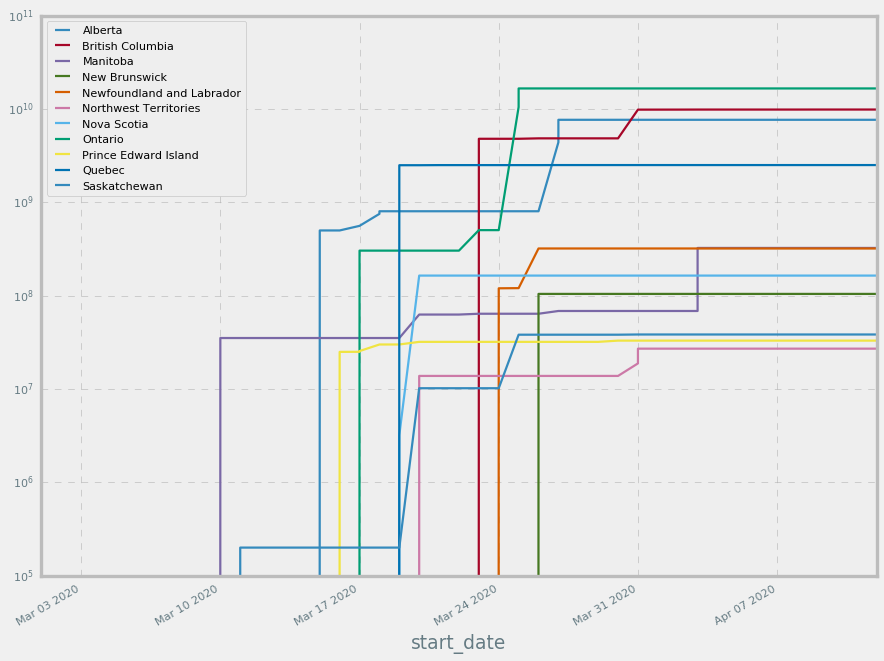

In [566]:
fig, ax = plt.subplots(figsize=(12,10))

dates = pd.date_range(start='03-01-2020', end='04-12-2020', name='dates').to_series() #mm-dd-yyyy
gb = provinces_df[provinces_df['oxford_fiscal_measure_cad'].notna()][['start_date', 'region', 'oxford_fiscal_measure_cad']].groupby(by='region')

for g_name, g_df in gb:
    all_dates_df = g_df.join(dates, on='start_date', how='right')
    all_dates_df['oxford_fiscal_measure_cad'] = all_dates_df['oxford_fiscal_measure_cad'].fillna(0)
    all_dates_df = all_dates_df.sort_values(by='start_date', ascending=True)
    all_dates_df['oxford_fiscal_measure_cad_cumsum'] = all_dates_df['oxford_fiscal_measure_cad'].cumsum(axis=0)
    #print(all_dates_df)

    all_dates_df.plot(x='start_date', y='oxford_fiscal_measure_cad_cumsum', label=g_name, ax=ax)

plt.yscale('log')

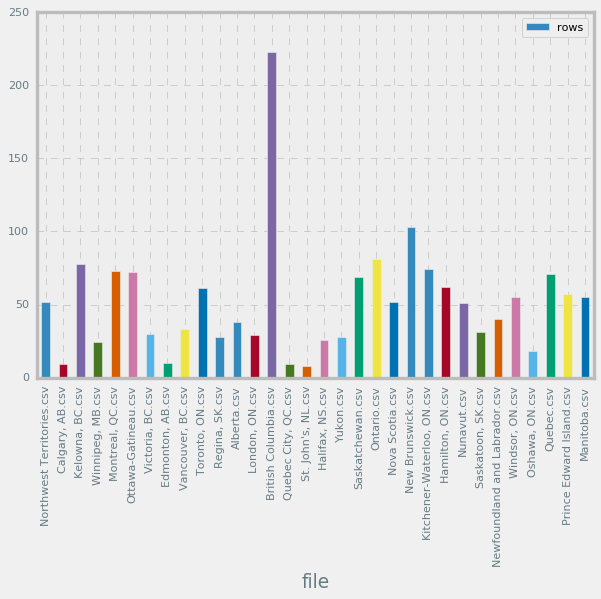

In [567]:
stats_df.plot.bar(x='file', y='rows')

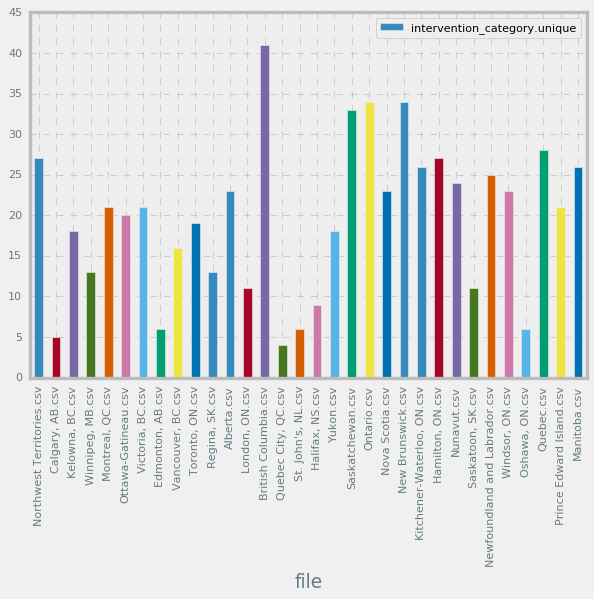

In [568]:
stats_df.plot.bar(x='file', y='intervention_category.unique')

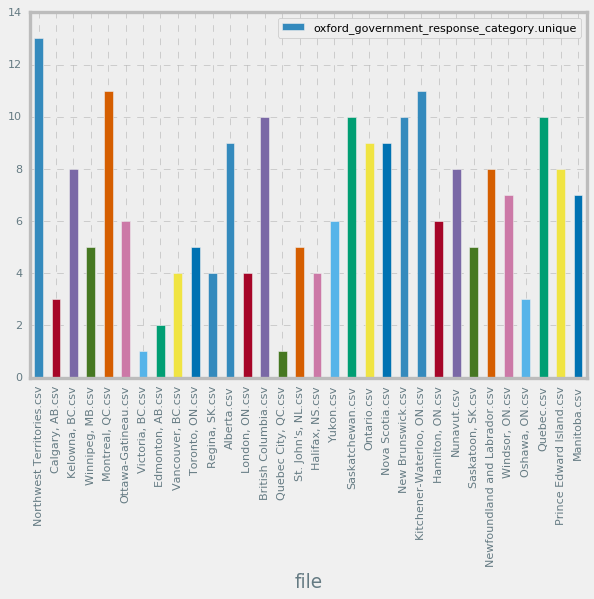

In [569]:
stats_df.plot.bar(x='file', y='oxford_government_response_category.unique')

In [570]:
stats_provs_df = stats_df[stats_df['file'].isin(province_files)]

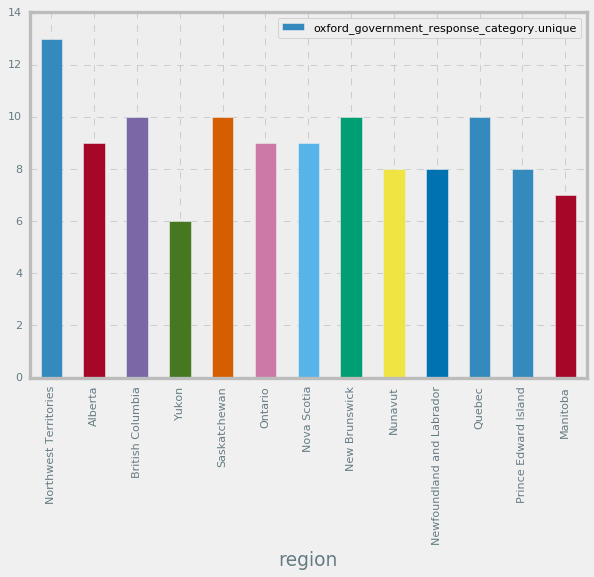

In [571]:
stats_provs_df.plot.bar(x='region', y='oxford_government_response_category.unique')

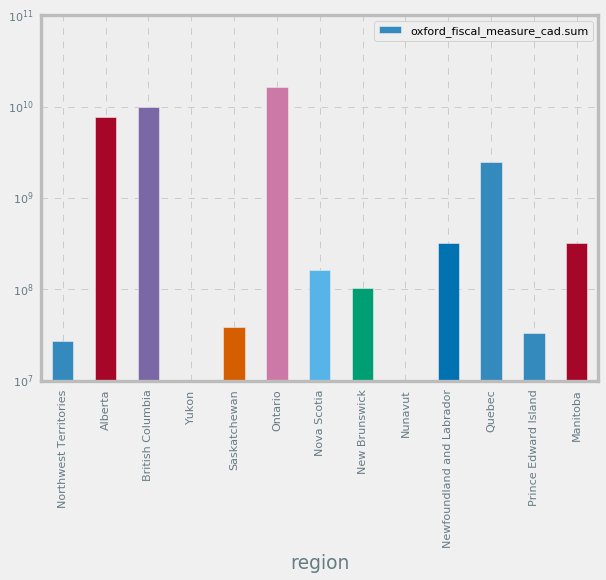

In [572]:
stats_provs_df.plot.bar(x='region', y='oxford_fiscal_measure_cad.sum', log=True)

In [573]:
a_df = stats_provs_df[['region', 'oxford_fiscal_measure_cad.sum']].merge(population_df, on='region', how='left')
a_df['population_q1_2020_hundred_thousands'] = a_df['population_q1_2020']
a_df['fiscal_normalized'] = a_df['oxford_fiscal_measure_cad.sum'] / a_df['population_q1_2020_hundred_thousands']

Text(0,0.5,'$ / person')

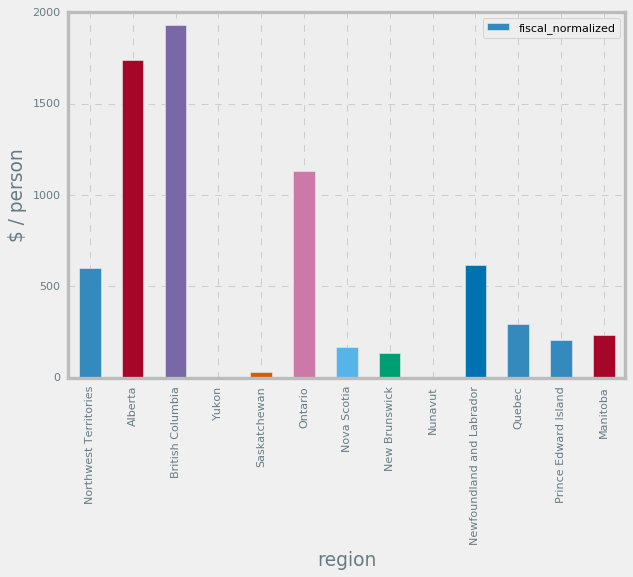

In [574]:
a_df.plot.bar(x='region', y='fiscal_normalized')
plt.ylabel('$ / person')

## Comparison of Ontario Interventions with Case Data

In [2]:
test_data_path = '../../data/covid19/'
df_c19test_on = pd.read_csv( data_path + 'test_data_on.csv' )

In [5]:
df_npi_on = pd.read_csv( './npi_ontario.csv' )

In [30]:
dates_int_counts = df_npi_on.groupby(by='start_date').count()['intervention_category']

In [43]:
graph_scale=20
ninterventions = df_npi_on.groupby(by='start_date').count()['intervention_category'].values * graph_scale

In [44]:
ndates = list(df_npi_on.groupby(by='start_date').groups.keys())

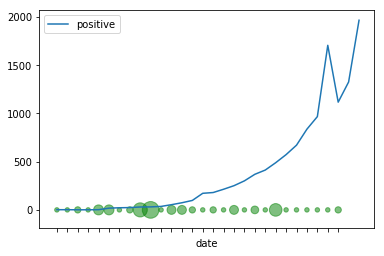

In [48]:
df_c19test_on.plot(x='date', y='positive')
plt.scatter(x=ndates, y=np.zeros(len(ndates)), s=ninterventions, c='g', label='interventions', alpha=0.5)

# LDA on Intervention text

In [587]:
full_text = full_df['source_full_text'].drop_duplicates().astype(str)

In [588]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

n_words = 10000

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_words, stop_words='english')
tf = tf_vectorizer.fit_transform( full_text )
tf_feature_names = tf_vectorizer.get_feature_names()

In [589]:
n_topics = 10

lda = LatentDirichletAllocation(n_components=n_topics, 
    max_iter=5, 
    learning_method='online',
    learning_offset=50.,
    random_state=0).fit(tf)

In [590]:
n_top_words = 10
for topic_i, topic in enumerate(lda.components_):
    print( "Topic ", topic_i )
    print( "Words: ", [tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]] )

Topic  0
Words:  ['2020', 'march', 'public', 'health', 'winnipeg', 'nunavut', 'information', 'parking', 'covid', 'services']
Topic  1
Words:  ['health', '19', 'covid', 'public', 'care', 'services', 'ca', 'city', 'people', 'march']
Topic  2
Words:  ['nan', 'dated', 'pei', 'team', 'paragraph', 'nwt', 'mr', '123', 'games', 'winter']
Topic  3
Words:  ['waterloo', 'township', 'edc', 'cambridge', 'firms', 'tony', 'dumfries', 'stortz', 'bstortz', 'chamber']
Topic  4
Words:  ['electricity', 'power', 'territories', 'agreement', 'northwest', 'utilities', 'mutual', 'atco', 'aid', 'ntpc']
Topic  5
Words:  ['nan', 'games', 'nwt', '867', 'territories', 'northwest', 'nu', 'nt', 'yellowknife', 'inspector']
Topic  6
Words:  ['la', 'les', 'et', 'le', 'des', 'pour', 'en', 'du', 'que', 'santé']
Topic  7
Words:  ['manitoba', 'manitobans', 'mb', '315', 'links', '8200', '788', 'nunavut', '204', '9257']
Topic  8
Words:  ['2020', 'services', 'parking', 'québec', 'order', 'du', 'march', 'dated', 'population', '

In [591]:
full_summaries = full_df['intervention_summary'].drop_duplicates().astype(str)

In [592]:

n_words = 10000

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=n_words, stop_words='english')
tf = tf_vectorizer.fit_transform( full_summaries )
tf_feature_names = tf_vectorizer.get_feature_names()

n_topics = 10

lda = LatentDirichletAllocation(n_components=n_topics, 
    max_iter=5, 
    learning_method='online',
    learning_offset=50.,
    random_state=0).fit(tf)

n_top_words = 10
for topic_i, topic in enumerate(lda.components_):
    print( "Topic ", topic_i )
    print( "Words: ", [tf_feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]] )

Topic  0
Words:  ['employees', 'government', 'employers', 'services', 'travel', 'leave', 'ensure', 'working', 'respiratory', 'sick']
Topic  1
Words:  ['covid', '19', 'case', 'confirmed', 'community', 'coronavirus', 'business', 'presumptive', 'region', 'information']
Topic  2
Words:  ['closed', 'facilities', 'public', 'closure', 'schools', 'city', 'centres', 'cancellation', 'programs', 'community']
Topic  3
Words:  ['home', 'work', 'online', 'assessment', 'tool', 'collection', 'employees', 'self', 'help', 'students']
Topic  4
Words:  ['new', 'cases', 'care', 'health', 'covid', '19', 'services', 'public', 'announcement', 'bc']
Topic  5
Words:  ['emergency', 'school', 'state', 'march', 'provincial', 'declared', 'suspended', 'suspension', 'classes', 'activities']
Topic  6
Words:  ['self', '14', 'days', 'isolate', 'travellers', 'distancing', 'social', 'recommendation', 'returning', 'non']
Topic  7
Words:  ['people', 'gatherings', 'public', 'city', '50', 'events', 'parking', 'person', '10', 